In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import torch.optim as optim

In [2]:
num_classes = 4
num_features = 2
random_seed = 23

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5,
                            random_state=random_seed)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=random_seed)

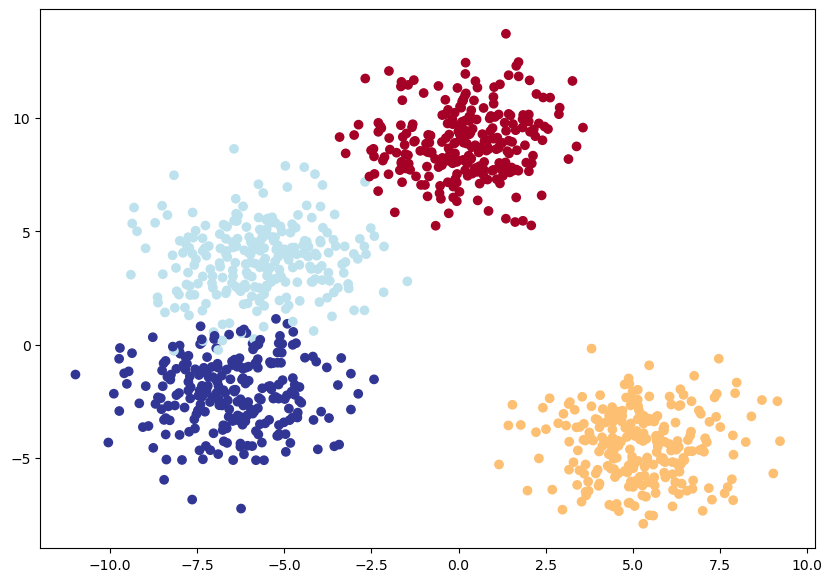

In [3]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
y_blob_train[3]

tensor(1)

In [18]:
class BlobModel(nn.Module):
    def __init__(self, input_features=2, num_classes=4):
        super(BlobModel, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=num_classes)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [19]:
model = BlobModel().to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)

epochs = 5001
X_train, y_train, X_test, y_test = X_blob_train.to(device), y_blob_train.to(device), X_blob_test.to(device), y_blob_test.to(device)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [23]:
def check_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = check_accuracy(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = check_accuracy(y_test, test_preds)

    if epoch % 10 == 0:
        print(f'epoch: {epoch} | loss: {loss} | acc: {acc} | test_loss: {test_loss} | test_acc: {test_acc}')

epoch: 0 | loss: 1.411543846130371 | acc: 50.375 | test_loss: 1.493299961090088 | test_acc: 41.0
epoch: 10 | loss: 1.2869689464569092 | acc: 50.625 | test_loss: 1.4020750522613525 | test_acc: 45.5
epoch: 20 | loss: 1.19828462600708 | acc: 51.87500000000001 | test_loss: 1.3329989910125732 | test_acc: 52.5
epoch: 30 | loss: 1.128849983215332 | acc: 65.875 | test_loss: 1.2545734643936157 | test_acc: 65.5
epoch: 40 | loss: 1.0700182914733887 | acc: 73.75 | test_loss: 1.1803208589553833 | test_acc: 67.0
epoch: 50 | loss: 1.0195003747940063 | acc: 75.625 | test_loss: 1.121642827987671 | test_acc: 67.5
epoch: 60 | loss: 0.973470151424408 | acc: 75.875 | test_loss: 1.0714774131774902 | test_acc: 67.5
epoch: 70 | loss: 0.9294261336326599 | acc: 76.25 | test_loss: 1.0255111455917358 | test_acc: 67.5
epoch: 80 | loss: 0.8870012760162354 | acc: 76.25 | test_loss: 0.9829251766204834 | test_acc: 67.5
epoch: 90 | loss: 0.8463879227638245 | acc: 76.625 | test_loss: 0.943676233291626 | test_acc: 67.5
e

In [25]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

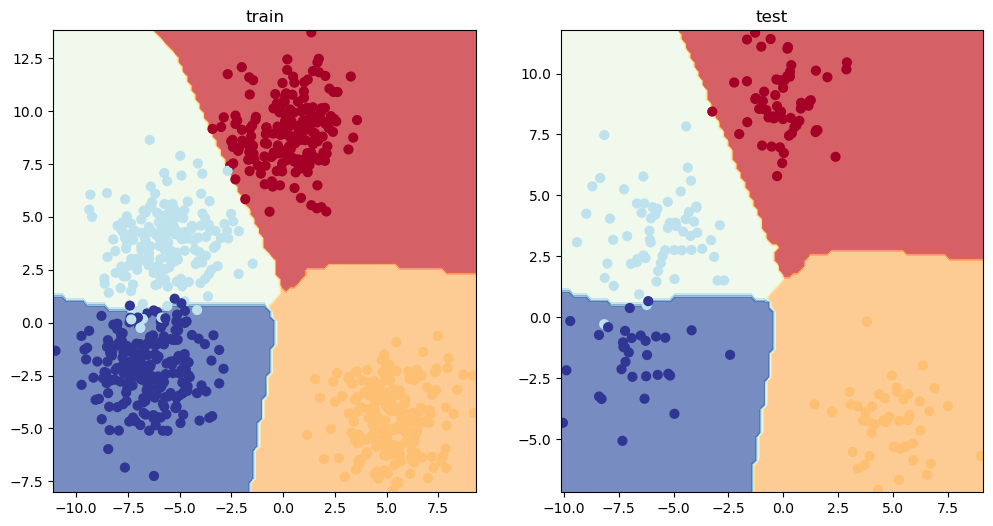

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model, X_test, y_test)